In [1]:
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd

In [2]:
def data_loader(path):
    table = pd.read_csv(path, index_col=[0])
    return table

In [3]:
df = data_loader('./data/laptops.csv')

In [4]:
def slice_df(table, col_name):
    test_df = table[table[col_name].isnull() == True]
    train_df = table[table[col_name].isnull() == False]
    return test_df, train_df

In [5]:
test_df, train_df = slice_df(df, 'rating')

- test_df : nan값이 있는 데이터, 최종 predict y를 넣어주어야 하는 데이터
- train_df : nan값이 없는 데이터, 학습 및 성능 확인이 되어야 하는 데이터

In [6]:
def slice_columns(*col_names):
    list = []
    for col in col_names:
        list.append(col)
    return list

In [7]:
sparse_col = slice_columns('img_link', 'name', 'processor', 'ram', 'os', 'storage')
dense_col = slice_columns('price(in Rs.)', 'display(in inch)')

- sparse_col : categorical columns
- dense_col : countable columns

In [8]:
def scaler_encoder(sparese, dense, target_df):
    target_df = target_df.copy()
    mms = MinMaxScaler(feature_range=(0, 1))
    target_df[dense] = mms.fit_transform(target_df[dense])
    for feat in sparese:
        lbe = LabelEncoder()
        target_df[feat] = lbe.fit_transform(target_df[feat])
    return target_df

In [9]:
train_df_transform = scaler_encoder(sparse_col, dense_col, train_df)
test_df_transform = scaler_encoder(sparse_col, dense_col, test_df)

In [10]:
train_df_transform

,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
0,292,271,0.142684,26,1,10,12,0.170940,4.5,14.0,1.0
1,320,277,0.065301,22,15,4,2,0.170940,4.4,53.0,3.0
2,242,56,0.103218,25,15,10,12,0.170940,4.4,4733.0,463.0
3,322,72,0.054645,21,15,4,12,0.170940,4.3,10406.0,1040.0
4,328,234,0.009107,1,11,7,10,0.102564,3.8,18.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
978,100,11,0.018215,18,12,6,12,0.102564,3.8,1135.0,167.0
979,89,73,0.066788,21,15,3,0,0.170940,4.0,1907.0,227.0
980,104,187,0.020279,45,13,6,0,0.000000,3.8,5991.0,687.0
981,300,42,0.118397,6,15,10,12,0.102564,4.5,22.0,5.0


- train_df_transform : train, 선학습 될 데이터의 전처리
- test_df_transform : test, 후학습 될 데이터의 전처리

In [11]:
def fixlen_feature(target_df, slice_sparse, slice_dense):
    fixlen_feature_columns = [SparseFeat(feat, target_df[feat].max() + 1, embedding_dim=4) for feat in slice_sparse] +\
        [DenseFeat(feat, 1, ) for feat in slice_dense]
    return fixlen_feature_columns

In [12]:
fixlen_feature_col = fixlen_feature(train_df_transform, sparse_col, dense_col)

In [13]:
fixlen_feature_col

[SparseFeat(name='img_link', vocabulary_size=401, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000022A38006670>, embedding_name='img_link', group_name='default_group', trainable=True),
 SparseFeat(name='name', vocabulary_size=357, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000022A38006280>, embedding_name='name', group_name='default_group', trainable=True),
 SparseFeat(name='processor', vocabulary_size=47, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000022A37E7CFA0>, embedding_name='processor', group_name='default_group', trainable=True),
 SparseFeat(name='ram', vocabulary_size=20, embedding_dim=4, use_has

In [14]:
def clone_feature(fix):
    dnn = fix
    linear = fix
    return dnn, linear

In [15]:
dnn, linear = clone_feature(fixlen_feature_col)

In [16]:
dnn

[SparseFeat(name='img_link', vocabulary_size=401, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000022A38006670>, embedding_name='img_link', group_name='default_group', trainable=True),
 SparseFeat(name='name', vocabulary_size=357, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000022A38006280>, embedding_name='name', group_name='default_group', trainable=True),
 SparseFeat(name='processor', vocabulary_size=47, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x0000022A37E7CFA0>, embedding_name='processor', group_name='default_group', trainable=True),
 SparseFeat(name='ram', vocabulary_size=20, embedding_dim=4, use_has

In [17]:
def get_feature_fun(dnn_feat, linear_feat):
    final = get_feature_names(linear_feat + dnn_feat)
    return final

In [18]:
final_feature_name = get_feature_fun(dnn, linear)

In [19]:
def train_test_slice(target_df, size, random, feature_col):
    train, test = train_test_split(target_df, test_size = size, random_state = random)
    train_model_input = {name : train[name] for name in feature_col}
    test_model_input = {name : test[name] for name in feature_col}
    return train, test, train_model_input, test_model_input

In [20]:
train_train, train_test, train_train_input, train_test_input = train_test_slice(train_df_transform, 0.2, 2020, final_feature_name)

In [21]:
def make_model(linear_feature_columns, dnn_feature_columns, activation):
    DEFAULT_GROUP_NAME = "default_group"
    model = DeepFM(linear_feature_columns, dnn_feature_columns, fm_group=(DEFAULT_GROUP_NAME,), dnn_hidden_units=(256, 128, 64),
           l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, seed=1024, dnn_dropout=0,
           dnn_activation=activation, dnn_use_bn=False, task='regression')
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
    return model

In [22]:
deepfm_model = make_model(linear, dnn, 'relu')

In [23]:
def fit_model(model, input_data, output_data, frequency):
    hist = model.fit(input_data, output_data, batch_size=256, epochs=frequency, verbose=2, validation_split=0.2)
    return hist

In [24]:
history = fit_model(deepfm_model, train_train_input, train_train['rating'].values, 300)

Epoch 1/300
2/2 - 2s - loss: 19.4677 - mse: 19.4676 - val_loss: 18.7886 - val_mse: 18.7886
Epoch 2/300
2/2 - 0s - loss: 18.8802 - mse: 18.8802 - val_loss: 18.2468 - val_mse: 18.2468
Epoch 3/300
2/2 - 0s - loss: 18.2946 - mse: 18.2946 - val_loss: 17.6532 - val_mse: 17.6532
Epoch 4/300
2/2 - 0s - loss: 17.6431 - mse: 17.6431 - val_loss: 16.9696 - val_mse: 16.9696
Epoch 5/300
2/2 - 0s - loss: 16.8885 - mse: 16.8885 - val_loss: 16.1501 - val_mse: 16.1501
Epoch 6/300
2/2 - 0s - loss: 15.9936 - mse: 15.9936 - val_loss: 15.1643 - val_mse: 15.1643
Epoch 7/300
2/2 - 0s - loss: 14.9177 - mse: 14.9176 - val_loss: 13.9801 - val_mse: 13.9801
Epoch 8/300
2/2 - 0s - loss: 13.6213 - mse: 13.6213 - val_loss: 12.5674 - val_mse: 12.5674
Epoch 9/300
2/2 - 0s - loss: 12.0930 - mse: 12.0930 - val_loss: 10.9064 - val_mse: 10.9064
Epoch 10/300
2/2 - 0s - loss: 10.3070 - mse: 10.3070 - val_loss: 8.9951 - val_mse: 8.9951
Epoch 11/300
2/2 - 0s - loss: 8.2683 - mse: 8.2683 - val_loss: 6.8746 - val_mse: 6.8746
Epo

In [25]:
def model_predict(model, test_input):
    pred = model.predict(test_input)
    return pred

In [26]:
train_train_pred = model_predict(deepfm_model, train_test_input)

In [27]:
import matplotlib.pyplot as plt

In [28]:
def test_plot(test_output, test_pred_output):
    plt.plot(test_output.reset_index(drop=True))
    plt.plot(test_pred_output)
    plt.show()

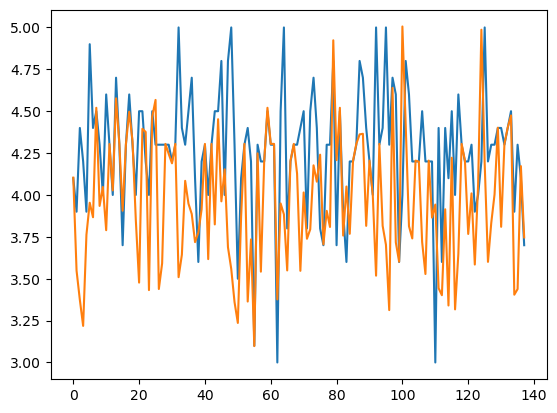

In [29]:
test_plot(train_test['rating'], train_train_pred)

In [56]:
def loss_plot(histo):
    plt.plot(histo.history['loss'])
    plt.plot(histo.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

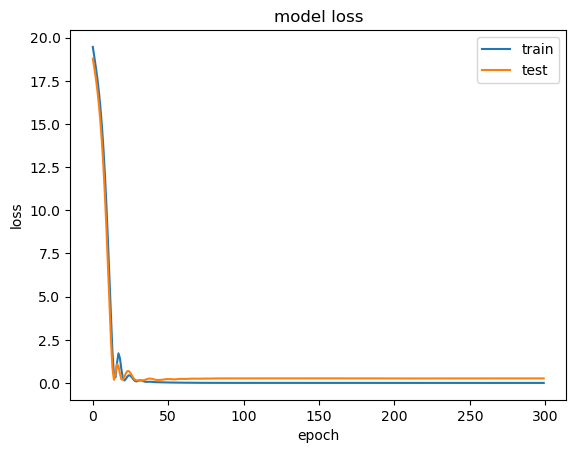

In [57]:
loss_plot(history)

In [40]:
def train_test_nonslice(target_df, feature_col):
    pred_y = {name: target_df[name] for name in feature_col}
    return pred_y

In [41]:
test_test = train_test_nonslice(test_df_transform, final_feature_name)

In [44]:
test_test_pred = model_predict(deepfm_model, test_test)

In [47]:
def pred_input(transform_target_df, pred_y_val, pred_y_colname):
    transform_target_df[pred_y_colname] = pred_y_val
    return transform_target_df


In [48]:
predict_test_df = pred_input(test_df_transform, test_test_pred, 'rating')

In [49]:
predict_test_df

,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
7,165,91,0.042250,1,13,1,7,0.421053,4.342304,NaN,NaN
53,162,0,0.280000,11,17,3,10,0.350877,4.965524,NaN,NaN
58,94,62,0.137500,18,16,1,10,0.421053,4.372184,NaN,NaN
64,92,116,0.175000,24,0,1,3,0.421053,4.724498,NaN,NaN
72,119,165,0.950000,31,8,5,5,0.947368,7.855472,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
971,165,91,0.042250,1,13,1,7,0.421053,4.342304,NaN,NaN
972,204,105,0.200022,19,0,5,10,0.701754,5.246991,NaN,NaN
975,189,173,0.462525,24,1,1,3,1.000000,7.267147,NaN,NaN
977,134,72,0.118775,18,0,1,10,0.701754,5.791061,NaN,NaN


In [53]:
def concat_col(predict_df, old_train_df):
    df_new = (pd.concat([predict_df, old_train_df], axis = 0)).sort_index()
    return df_new

In [54]:
df_new = concat_col(predict_test_df, train_df_transform)

In [55]:
df_new

,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
0,292,271,0.142684,26,1,10,12,0.170940,4.500000,14.0,1.0
1,320,277,0.065301,22,15,4,2,0.170940,4.400000,53.0,3.0
2,242,56,0.103218,25,15,10,12,0.170940,4.400000,4733.0,463.0
3,322,72,0.054645,21,15,4,12,0.170940,4.300000,10406.0,1040.0
4,328,234,0.009107,1,11,7,10,0.102564,3.800000,18.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
979,89,73,0.066788,21,15,3,0,0.170940,4.000000,1907.0,227.0
980,104,187,0.020279,45,13,6,0,0.000000,3.800000,5991.0,687.0
981,300,42,0.118397,6,15,10,12,0.102564,4.500000,22.0,5.0
982,148,147,0.075896,22,15,4,2,0.170940,4.000000,801.0,104.0
